# SEIR Model for COVID-19 Forecasting

In [1]:
%load_ext lab_black

# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from scipy.optimize import minimize, differential_evolution

# Other
import copy
from datetime import date, timedelta
import os
import random
import sys
from typing import List, Tuple

# Custom module
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join("../ygg_seir_simulator/"))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.seir_ygg_model import SEIRYGGForecaster
from src.plotting import plot_predictions
from src.utils import get_covid_data, get_all_covid_data, province_populations_dict

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

D:\Other\anaconda3\envs\covid-forecasting\lib\site-packages\ipykernel\parentpoller.py:110: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


## Purpose

The goal is to produce accurate forecasts of COVID-19 deaths and infections in Canada. One of the models we'll be focusing on is an SEIR model using a simulator based off of https://covid19-projections.com/model-details/.  

## Load Data

For the data we'll only be using mortality data as data on active infections and new infections can be innacurate and add noise to the model. The dataset can be found here https://github.com/ishaberry/Covid19Canada.

In [2]:
# Read in data
mortality_start_date = date(day=8, month=3, year=2020)
mortality_provinces = get_all_covid_data(level="prov").query(
    "date >= @mortality_start_date"
)

provinces = ["Alberta", "BC", "Ontario", "Quebec"]
mortality_end_date = mortality_provinces["date"].max()

mortality_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
43  Alberta  2020-03-08                 4                     0   
44  Alberta  2020-03-09                14                     0   
45  Alberta  2020-03-10                14                     0   
46  Alberta  2020-03-11                19                     0   
47  Alberta  2020-03-12                23                     0   
48  Alberta  2020-03-13                29                     0   
49  Alberta  2020-03-14                39                     0   
50  Alberta  2020-03-15                56                     0   
51  Alberta  2020-03-16                74                     0   
52  Alberta  2020-03-17                97                     0   

    cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
43                  0             4                    2       0          0   
44                  0            14                   10       0          0   
45                  0            14                    0       0          0   
46                  0            19                    5       0          0   
47                  0            23                    4       0          0   
48                  0            29                    6       0          0   
49                  0            39                   10       0          0   
50                  0            56                   17       0          0   
51                  0            74                   18       0          0   
52                  0            97                   23       0          0   

    cases  population  removed  cumulative_removed  susceptible  \
43      2     4421876        0                   0      4421872   
44     10     4421876        0                   0      4421862   
45      0     4421876        0                   0      4421862   
46      5     4421876        0                   0      4421857   
47      4     4421876        0                   0      4421853   
48      6     4421876        0                   0      4421847   
49     10     4421876        0                   0      4421837   
50     17     4421876        0                   0      4421820   
51     18     4421876        0                   0      4421802   
52     23     4421876        0                   0      4421779   

    percent_susceptible  
43             0.999999  
44             0.999997  
45             0.999997  
46             0.999996  
47             0.999995  
48             0.999993  
49             0.999991  
50             0.999987  
51             0.999983  
52             0.999978

## SEIR Parameter Estimation

First we would want to replace the simple grid search layer in the original model with more sophisticated optimization methods. We will be fine tuning the current model and so the only parameters we'll be tuning are:

- Mortality rate
- Initial $R_0$
- Lockdown $R_0$
- Imports of positive cases per day

To handle overfitting we'll be applying cross-validation. Since we are dealing with time series we will split our data a bit differently. The data will be split into folds in order from 1 to k and for each $i$ from 1 to k we will use train the model on the first 1 to i folds and validate on the remaining folds. For our loss function we'll be using root mean squared error (RMSE) on the cumulative sum of deaths and not use any of the data on cases/recovered since those reports can be innacurate and add noise to the model.

In each of the following estimation methods we'll be using Ontario data to give an example of the algorithm

### Differential evolution

In [3]:
%%time

forecasts = pd.DataFrame()

for province in provinces:
    model = SEIRYGGForecaster(
        method="differential_evolution",
        province=province,
        population=province_populations_dict[province],
        verbose=False,
    )

    mortality_prov= mortality_provinces.query('province == @province')
    model.fit(mortality_prov)
    province_forecasts = model.forecast(h=21)
    province_forecasts['province'] = province
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)
    forecasts.loc[:, "active_cases_pred"] = forecasts["infections_pred"]

Loading params file: ../models/best_params/latest/subregion\Canada_Alberta.json
Loading params file: ../models/best_params/latest/subregion\Canada_British-Columbia.json
Loading params file: ../models/best_params/latest/subregion\Canada_Ontario.json
Loading params file: ../models/best_params/latest/subregion\Canada_Quebec.json
Wall time: 8h 51min 27s


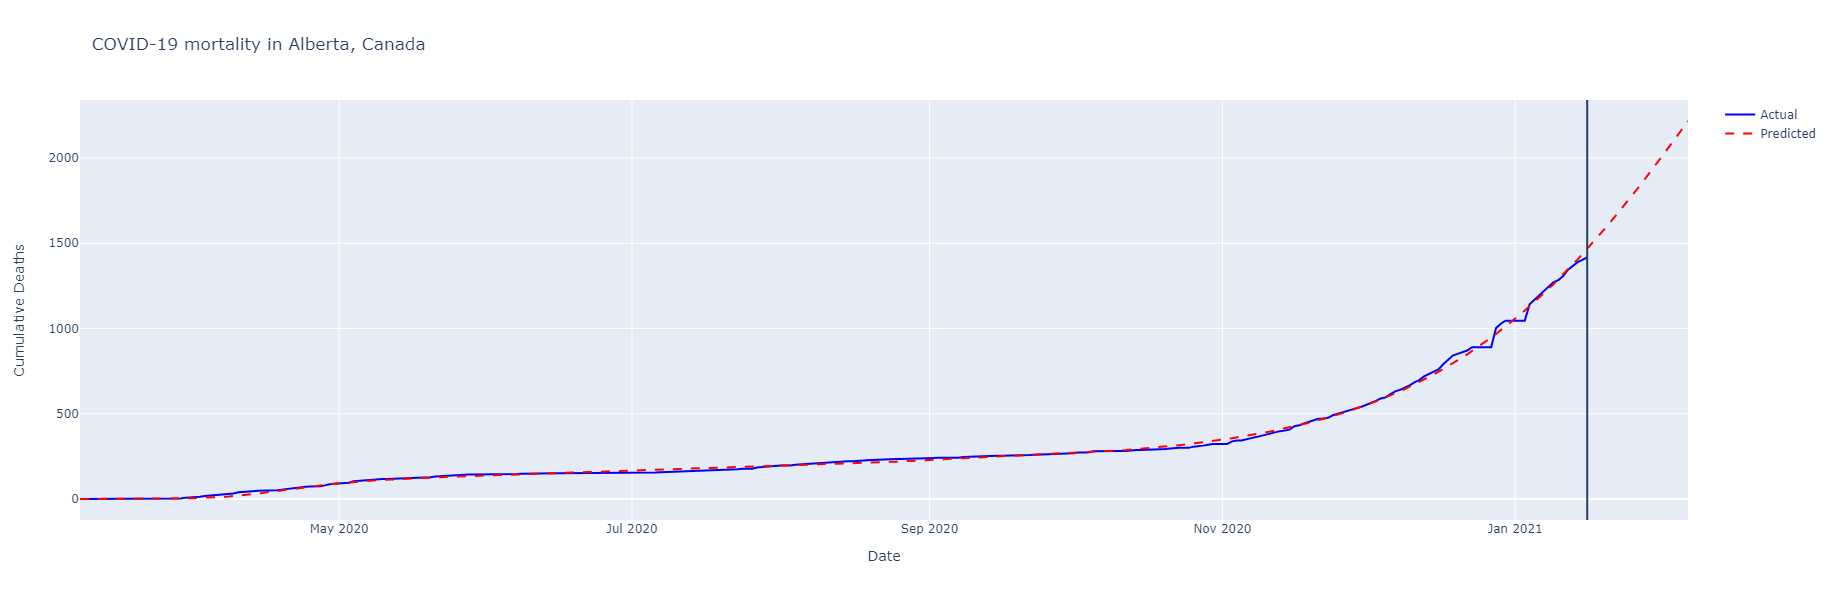

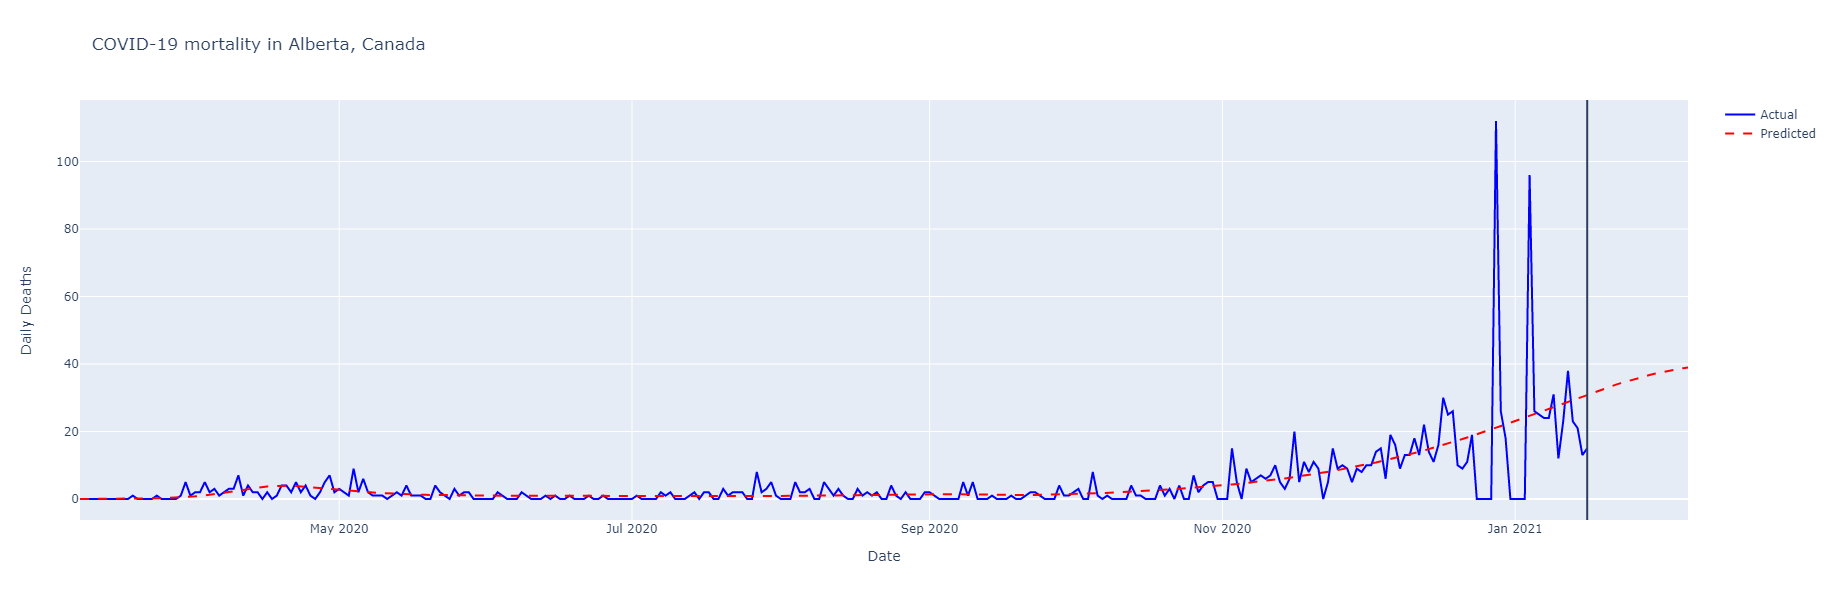

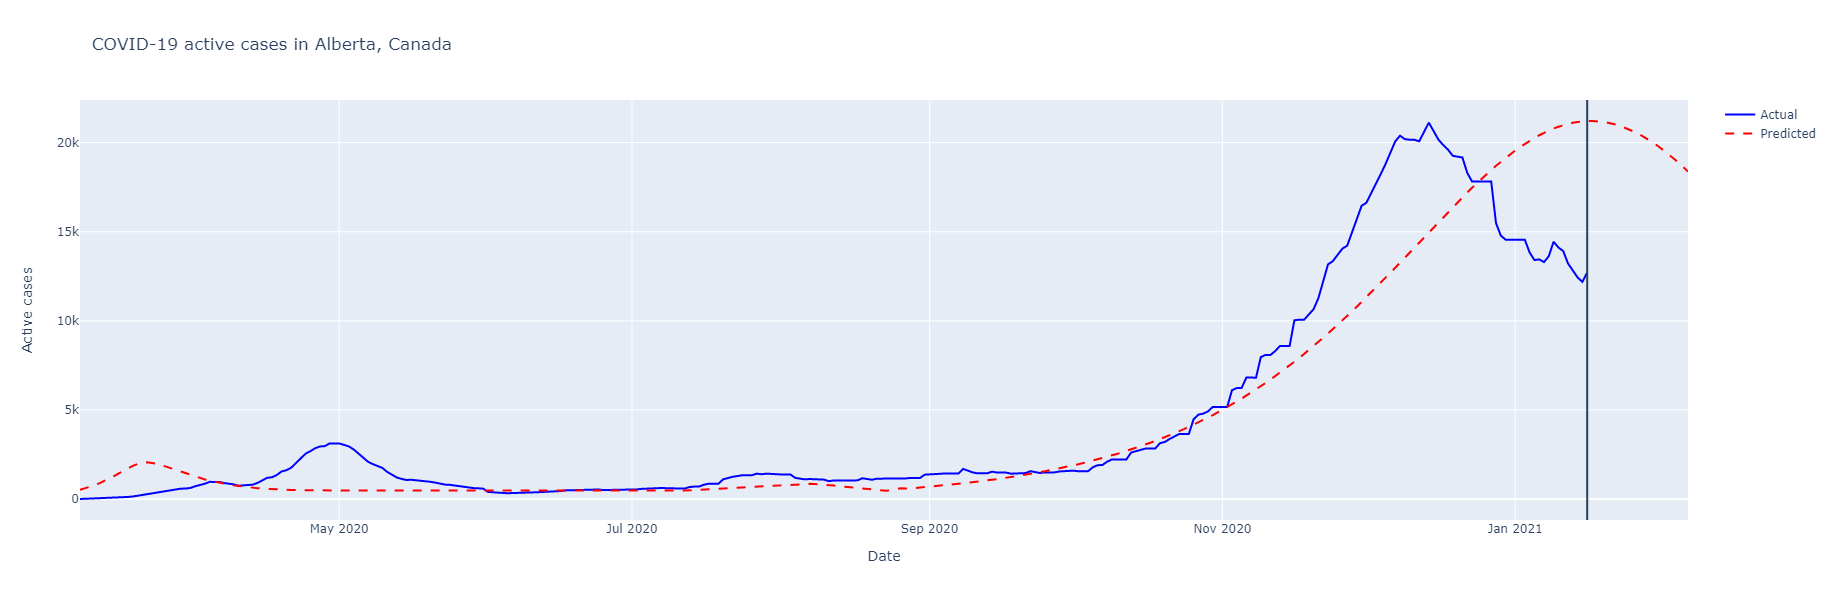

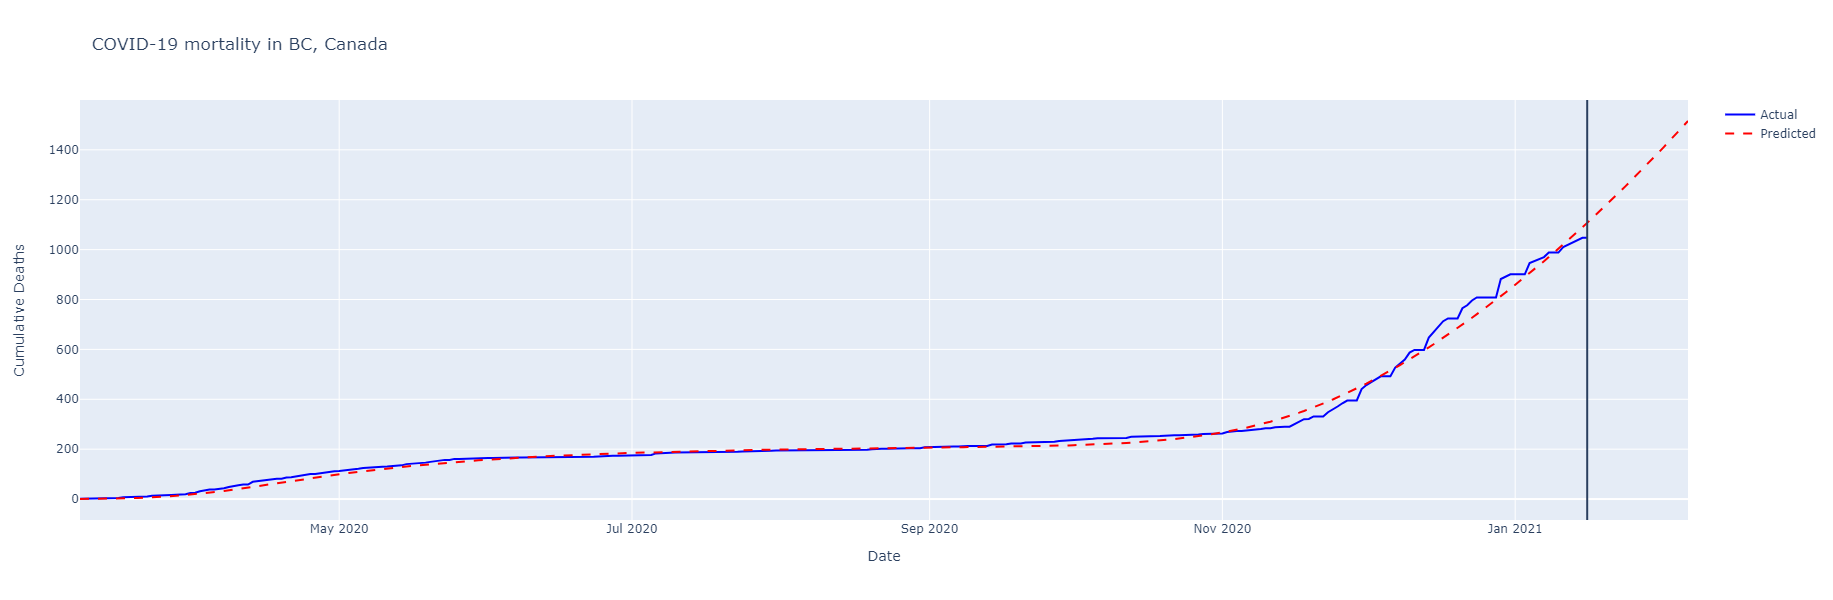

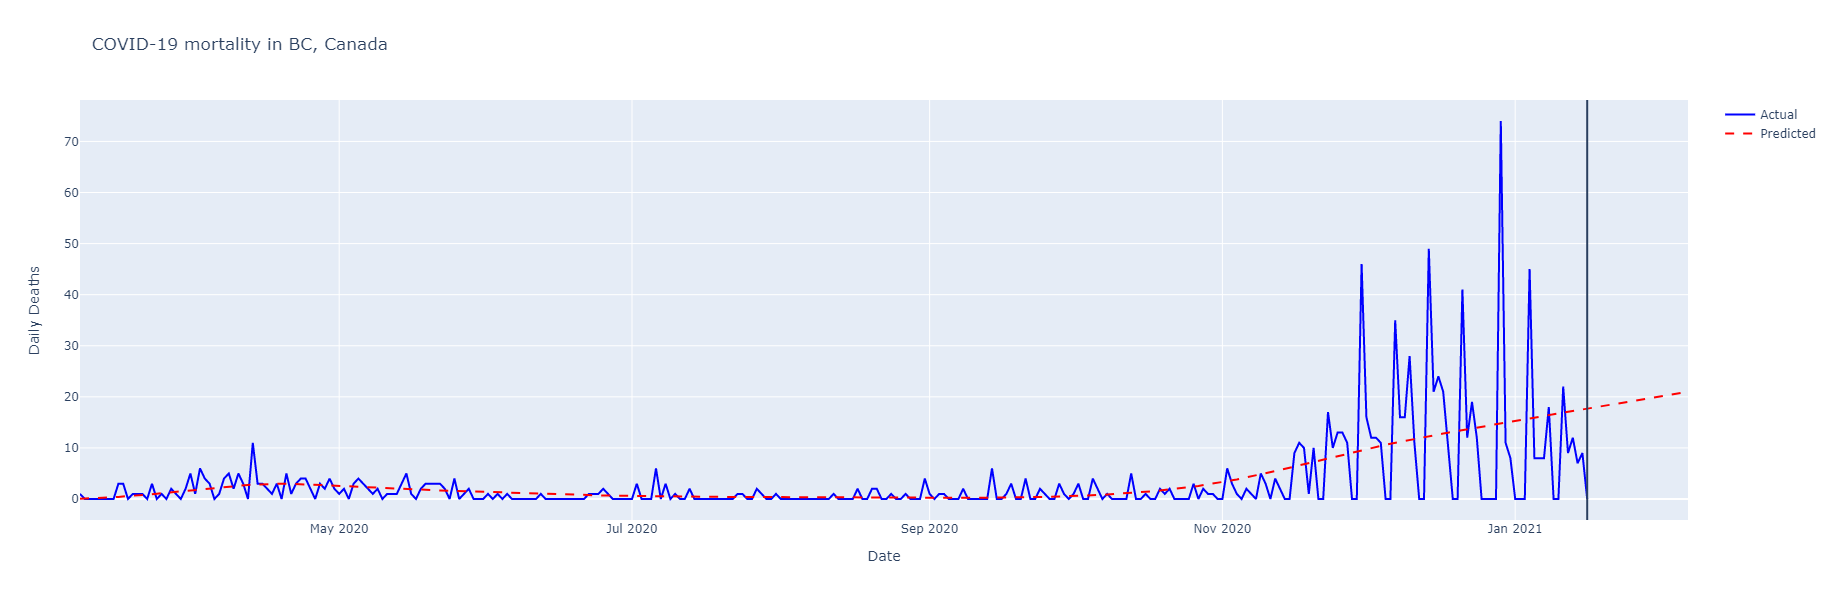

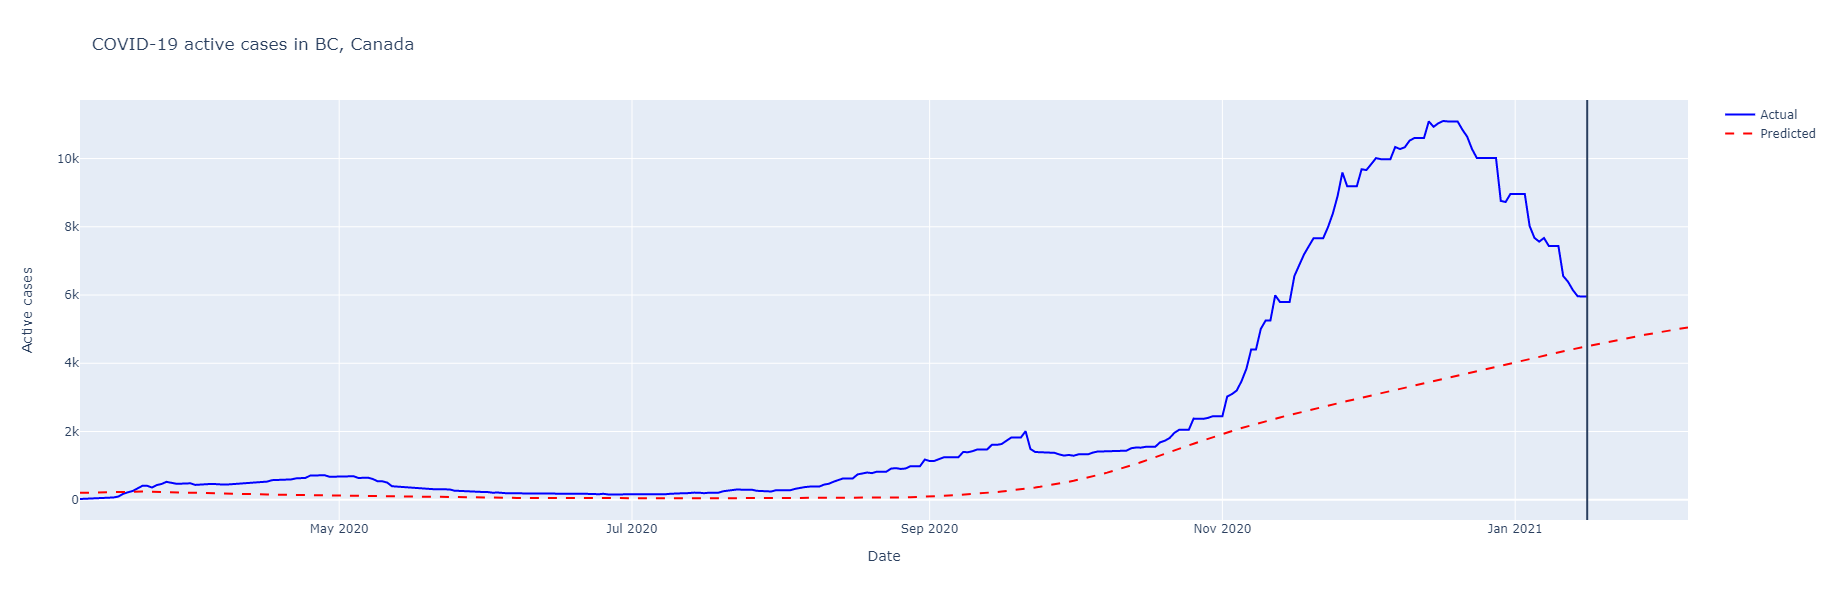

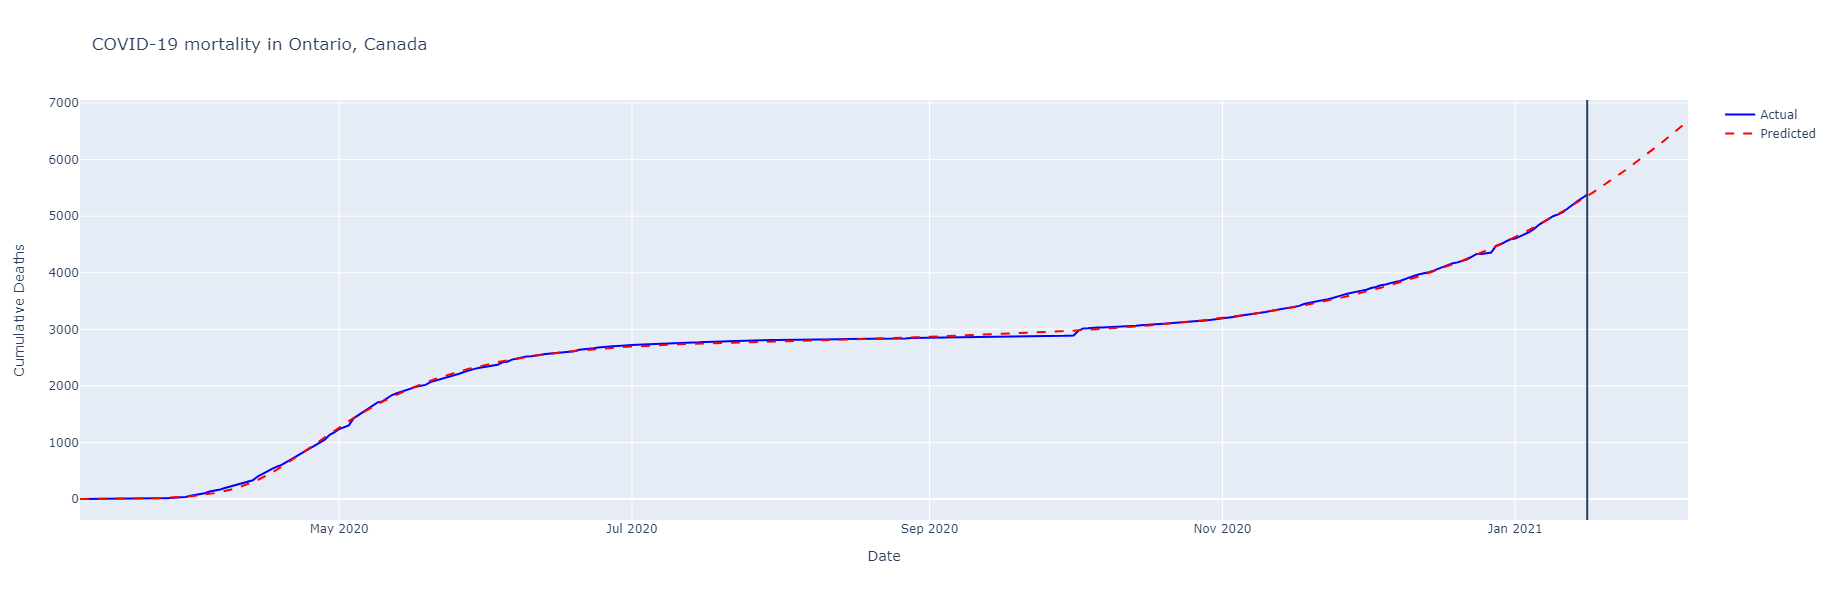

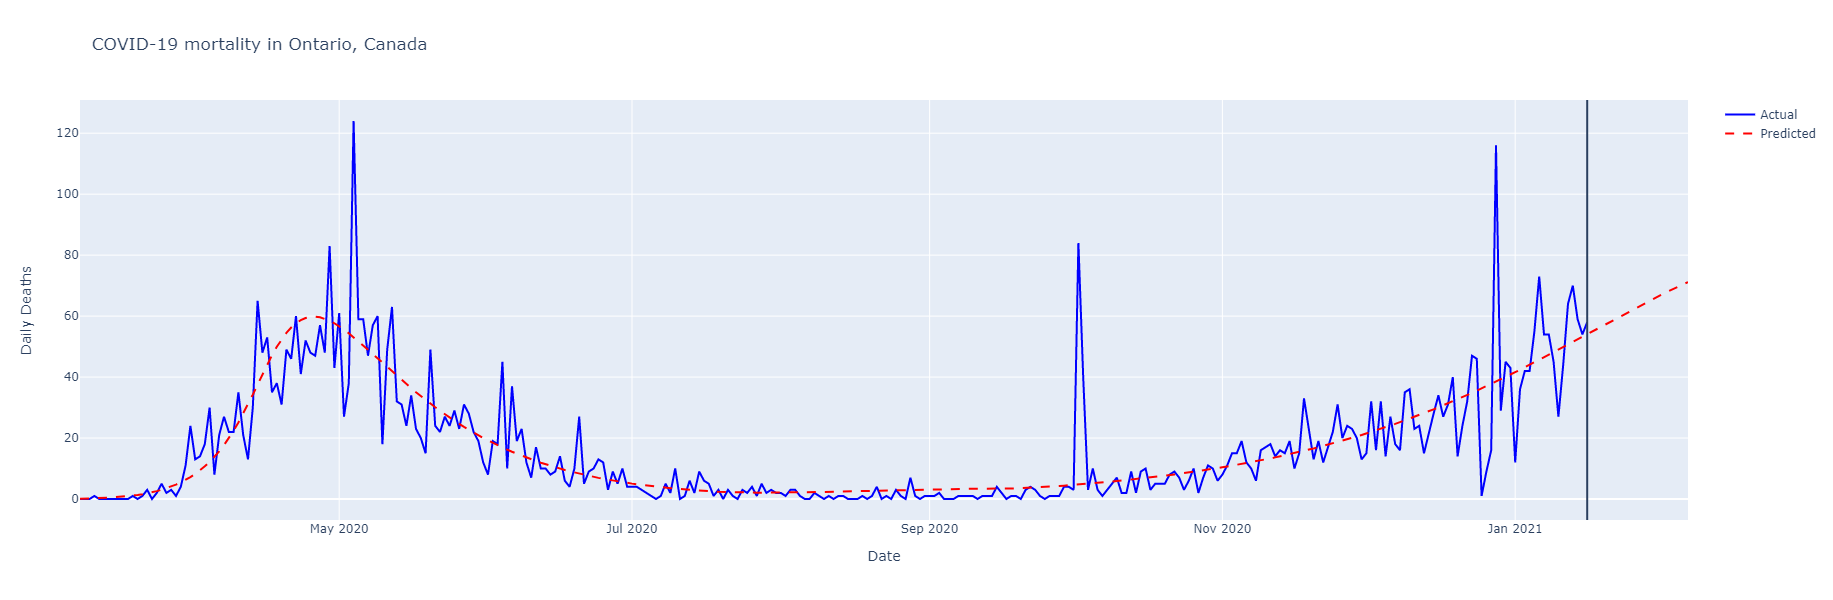

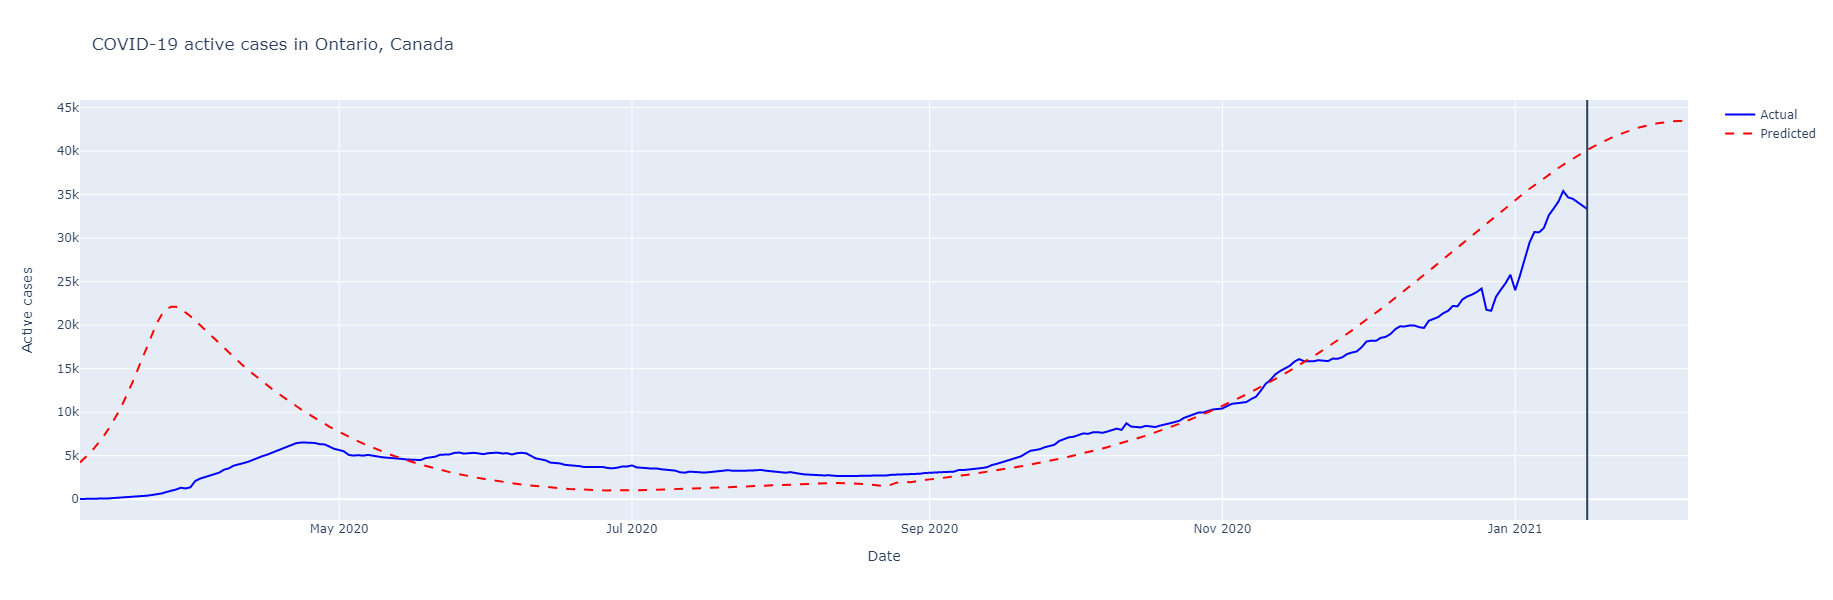

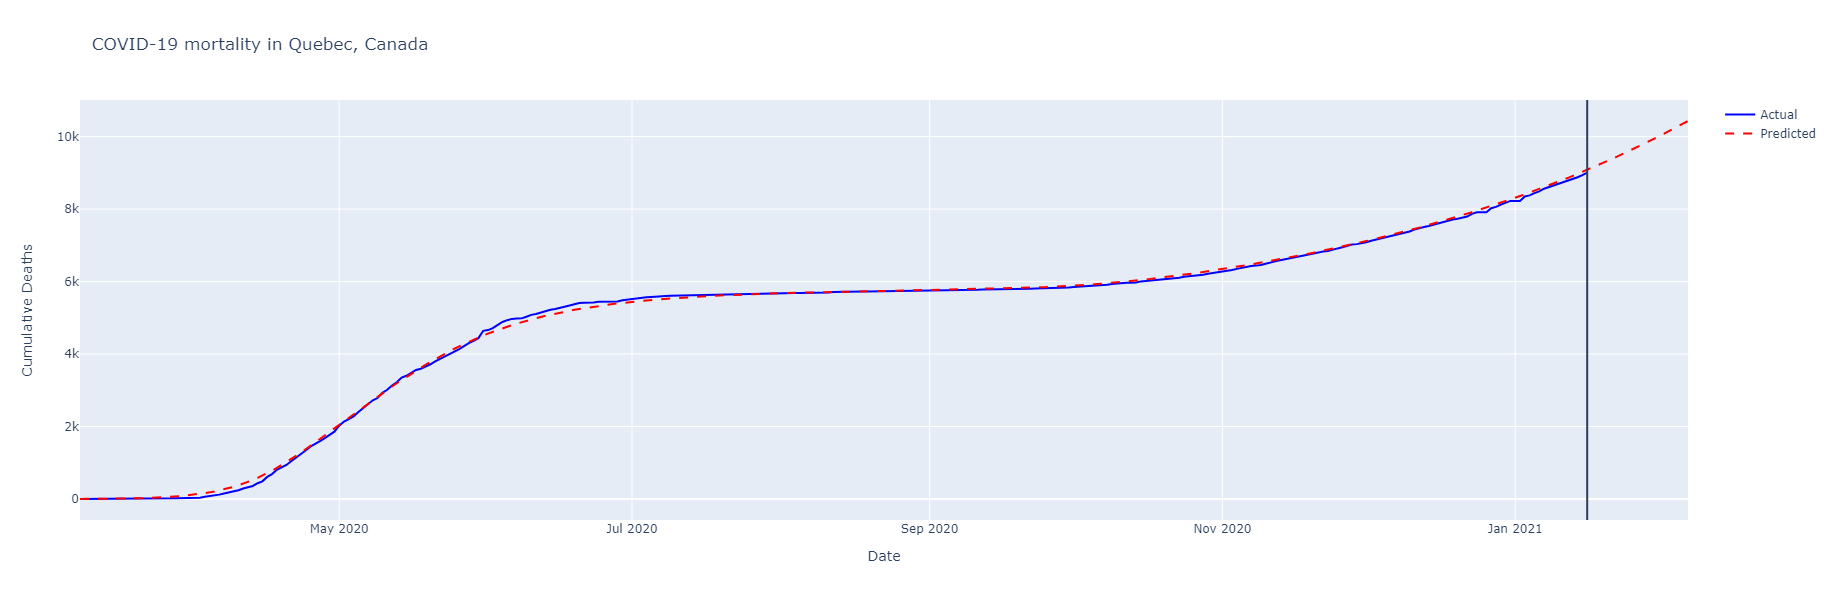

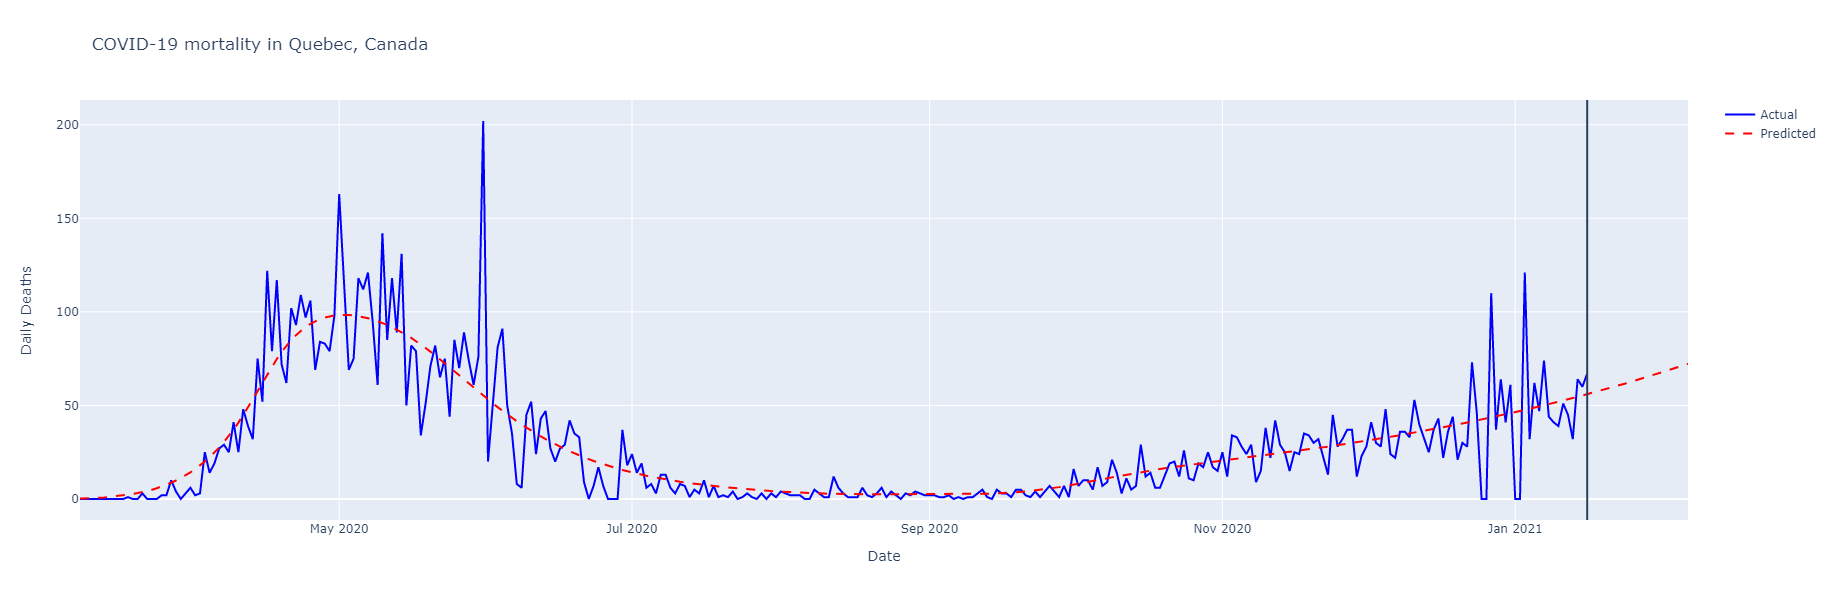

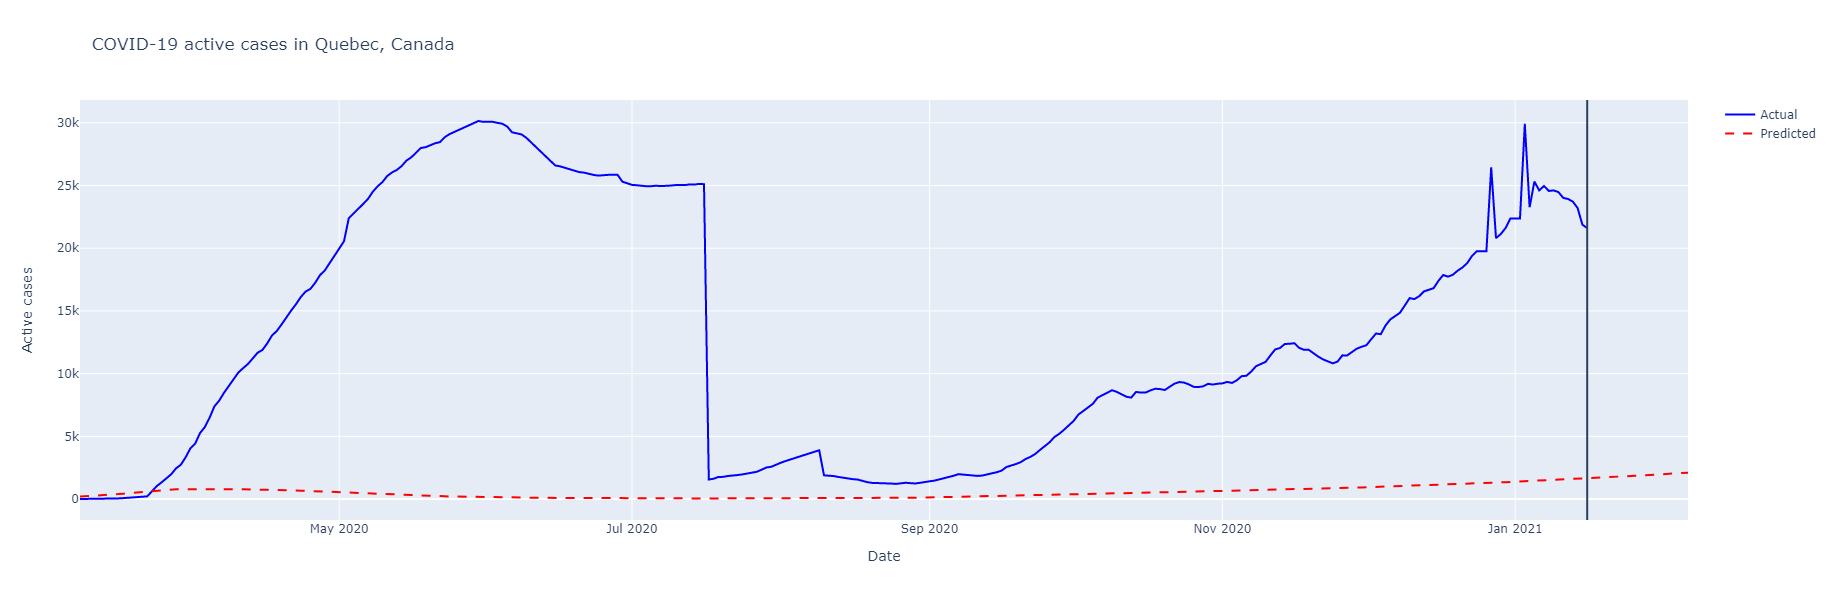

In [6]:
for province in provinces:
    province_forecasts = forecasts.query("province == @province")

    # Plot results for cumulative deaths
    plot_predictions(
        province_forecasts,
        y="cumulative_deaths",
        y_label="Cumulative Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

    # Plot results for daily deaths
    plot_predictions(
        province_forecasts,
        y="deaths",
        y_label="Daily Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

    # Plot results for daily deaths
    plot_predictions(
        province_forecasts,
        y="active_cases",
        y_label="Active cases",
        title=f"COVID-19 active cases in {province}, Canada",
        height=600,
    )

### L-BFGS-B Optimization

Bound constrained minimization implemented in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [7]:
%%time

forecasts = pd.DataFrame()

for province in provinces:
    model = SEIRYGGForecaster(
        method="L-BFGS-B",
        province=province,
        population=province_populations_dict[province],
        verbose=False,
    )

    mortality_prov= mortality_provinces.query('province == @province')
    model.fit(mortality_prov)
    province_forecasts = model.forecast(h=21)
    province_forecasts['province'] = province
    forecasts = pd.concat([forecasts, province_forecasts], ignore_index=True)
    forecasts.loc[:, "active_cases_pred"] = forecasts["infections_pred"]

Loading params file: ../models/best_params/latest/subregion\Canada_Alberta.json
Loading params file: ../models/best_params/latest/subregion\Canada_British-Columbia.json
Loading params file: ../models/best_params/latest/subregion\Canada_Ontario.json
Loading params file: ../models/best_params/latest/subregion\Canada_Quebec.json
Wall time: 1min 43s


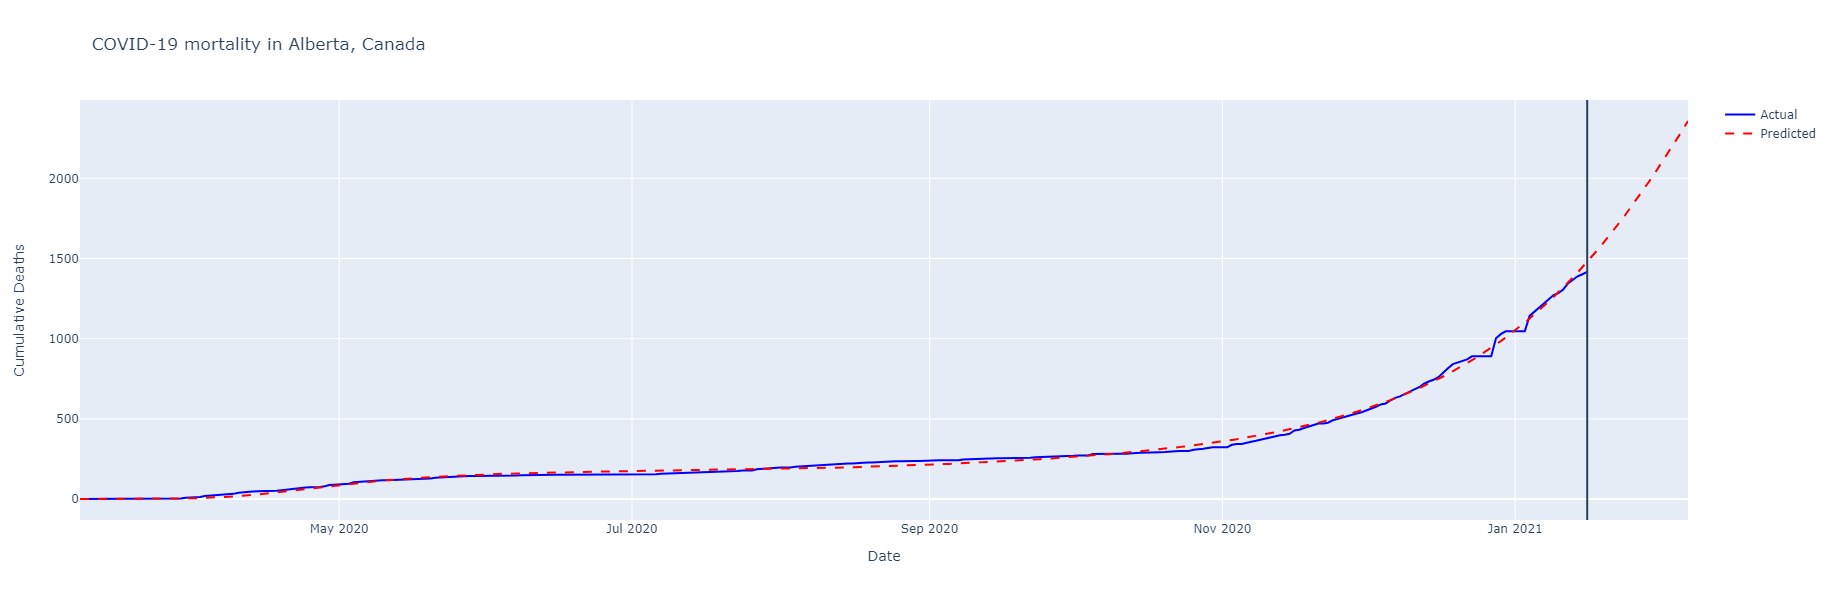

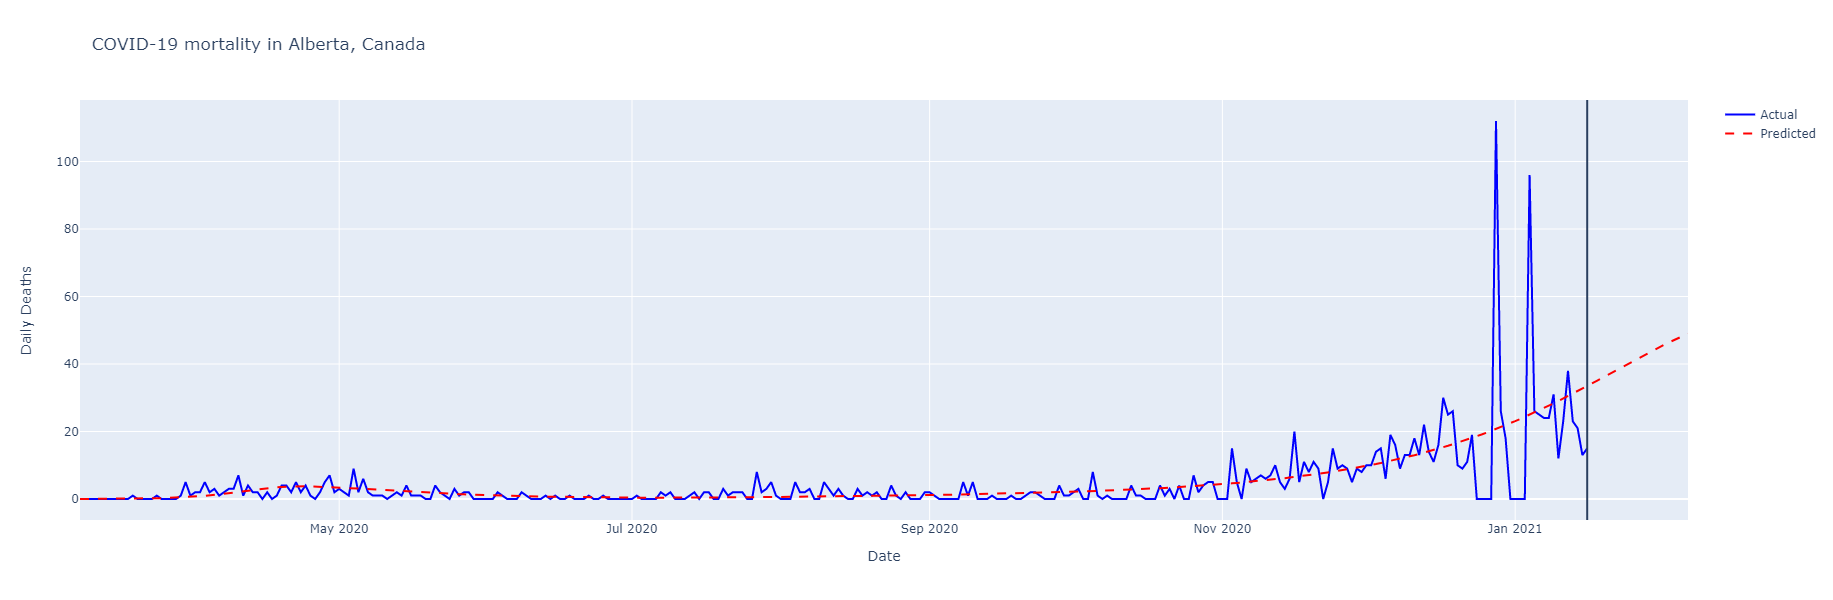

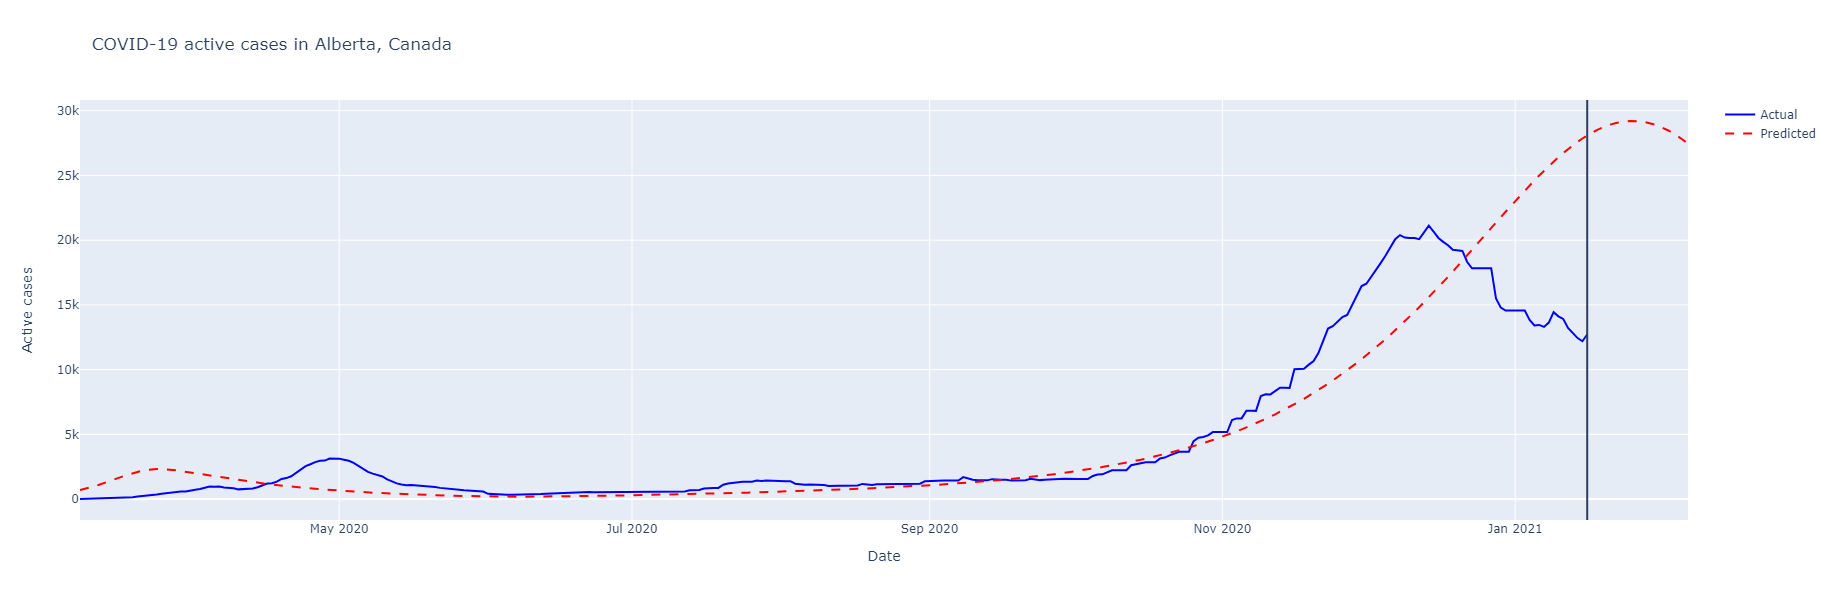

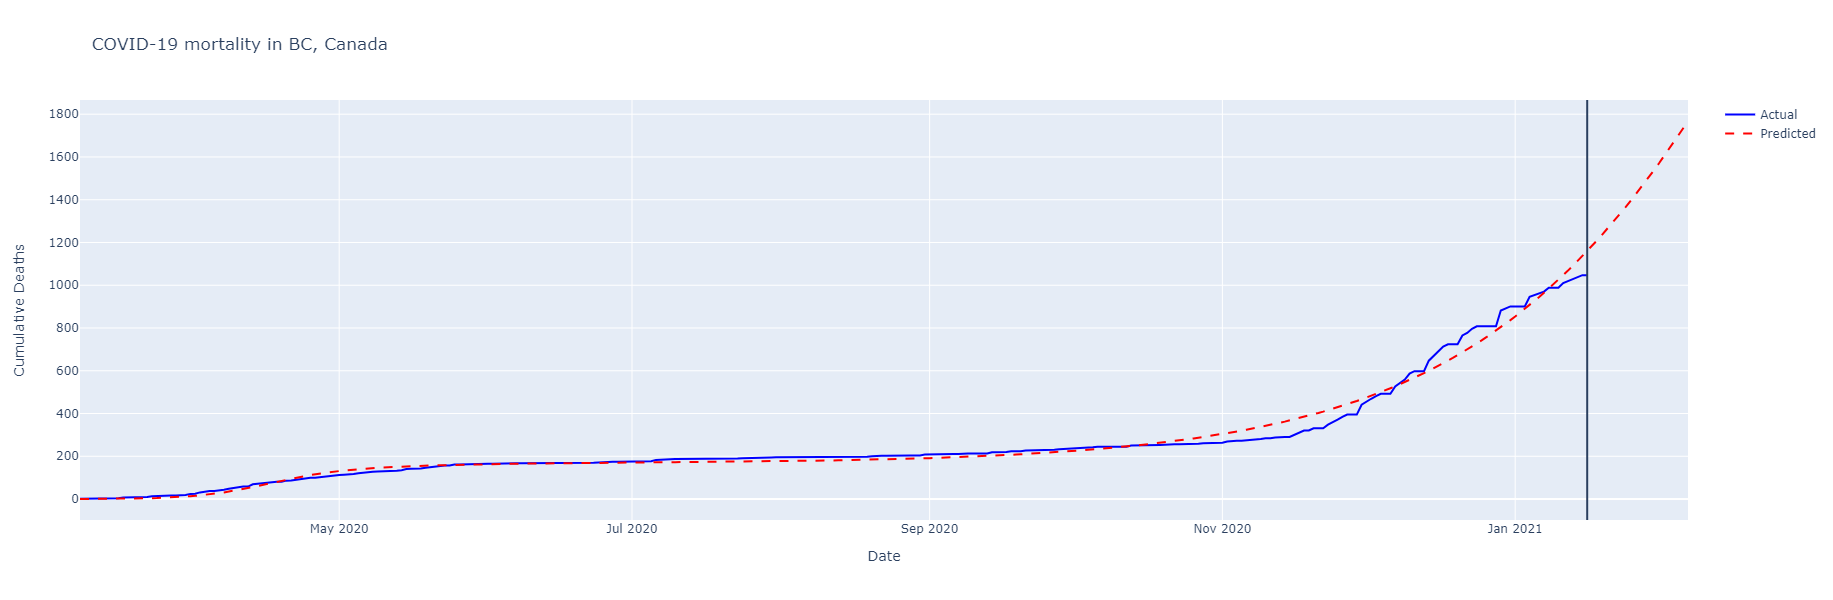

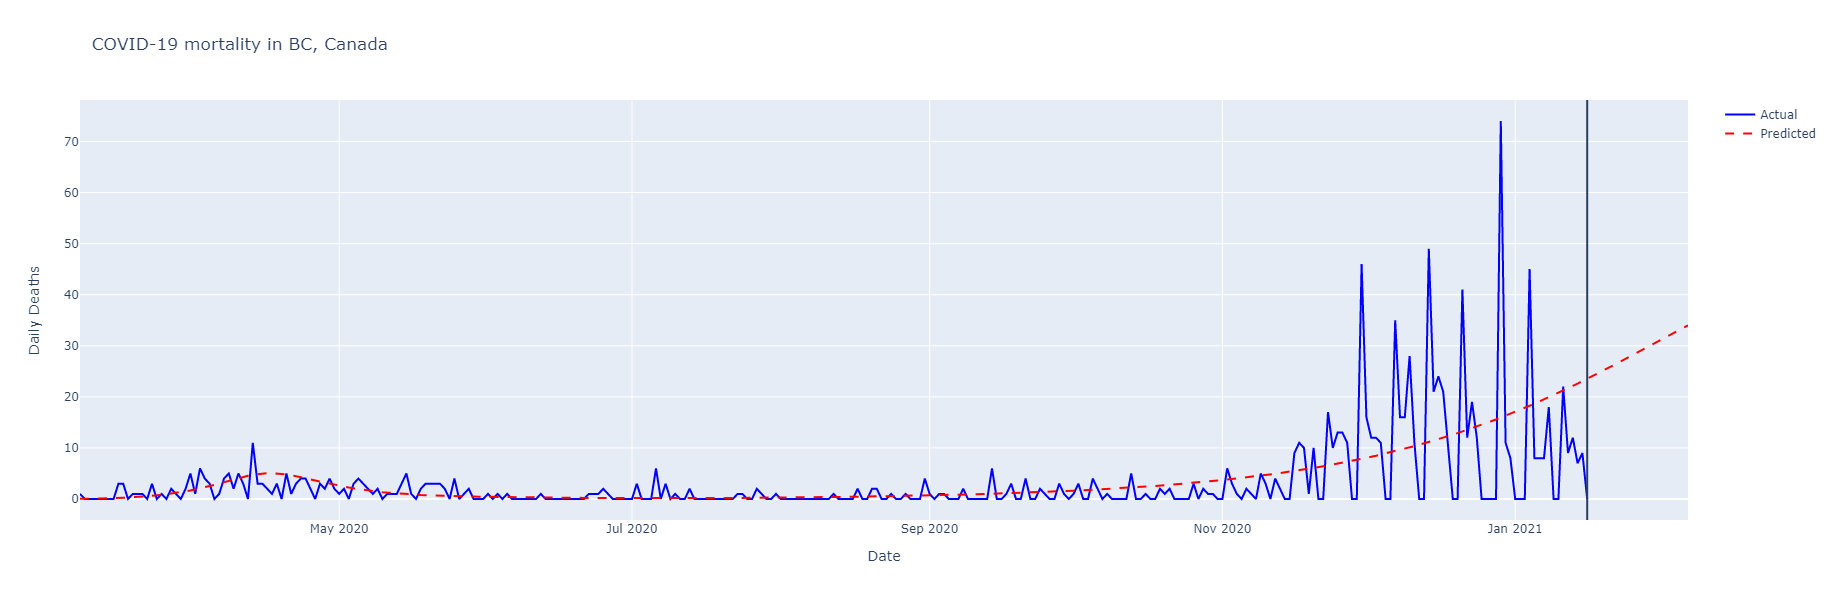

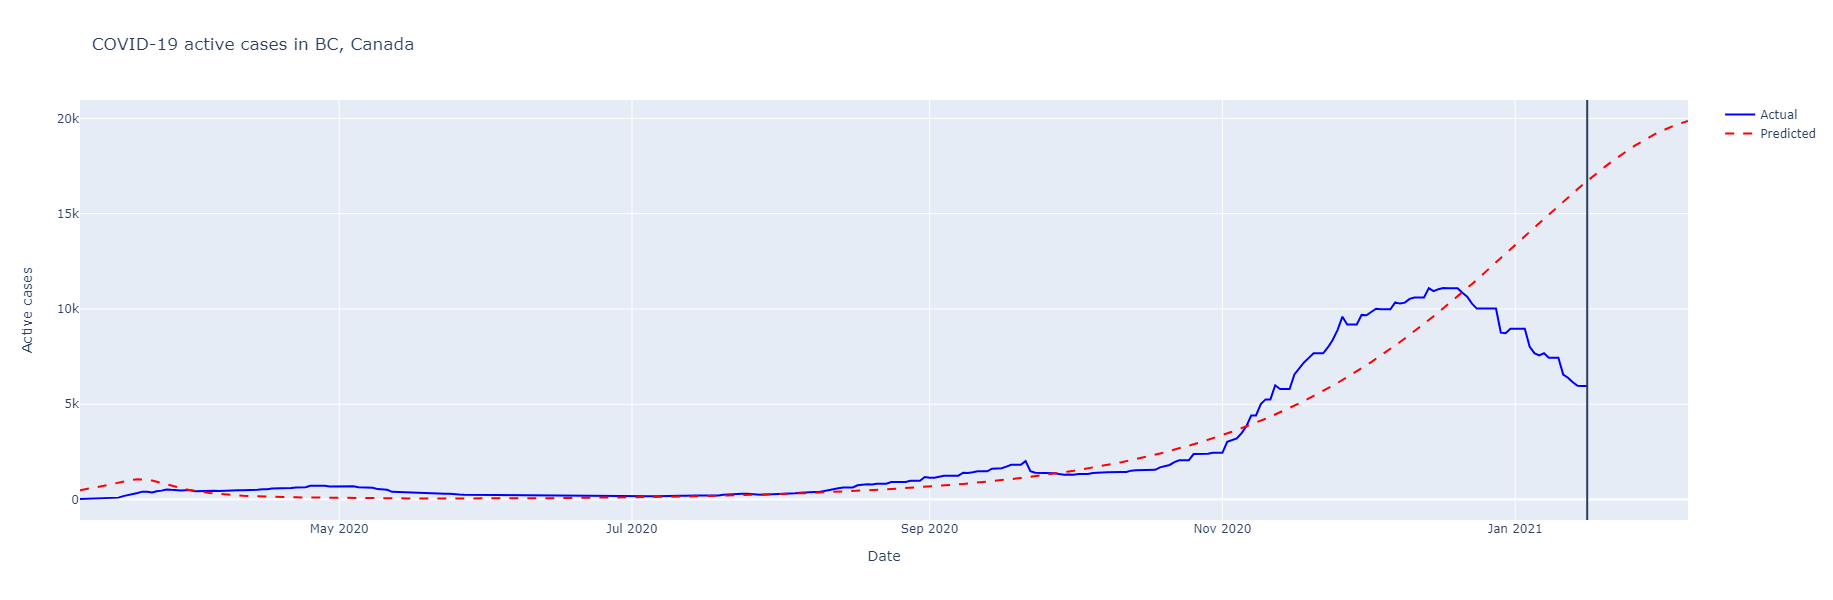

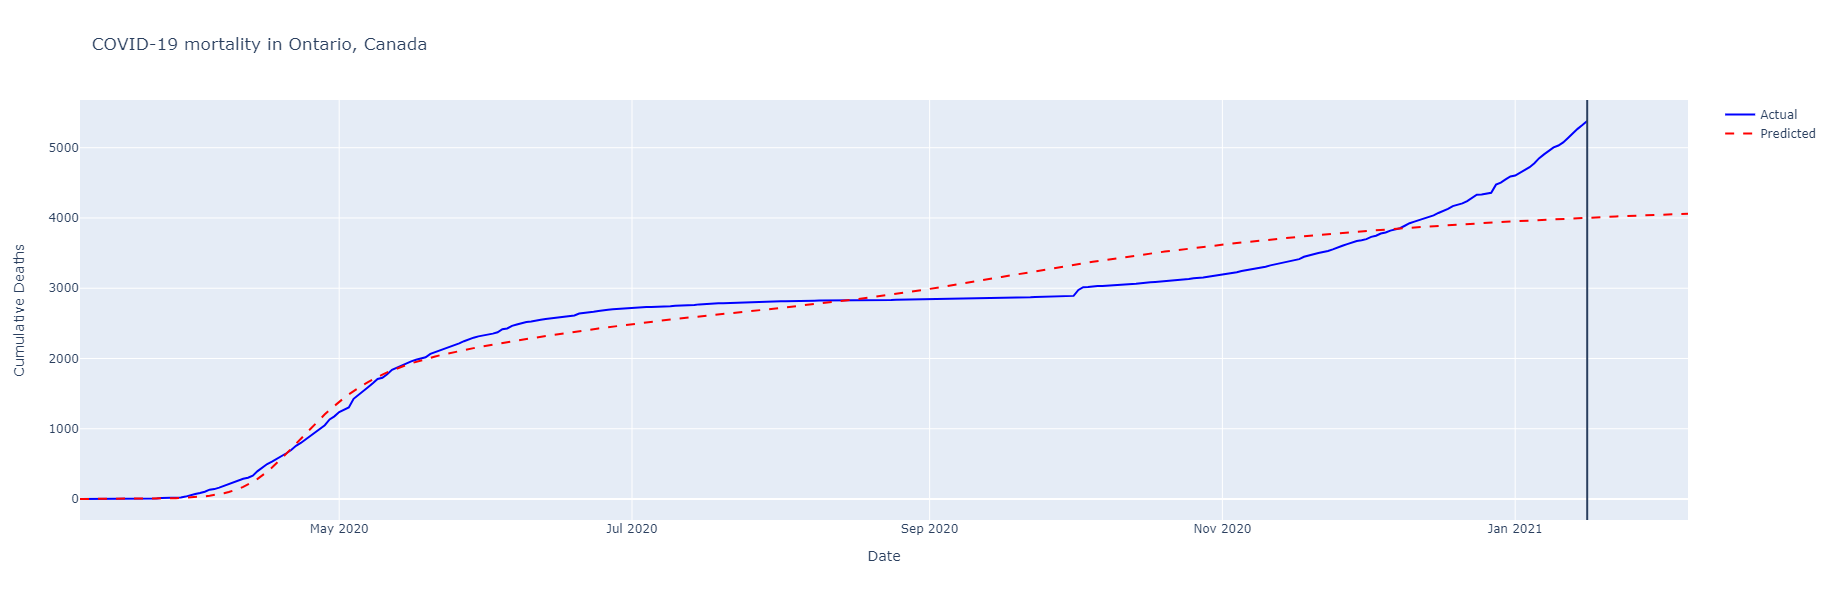

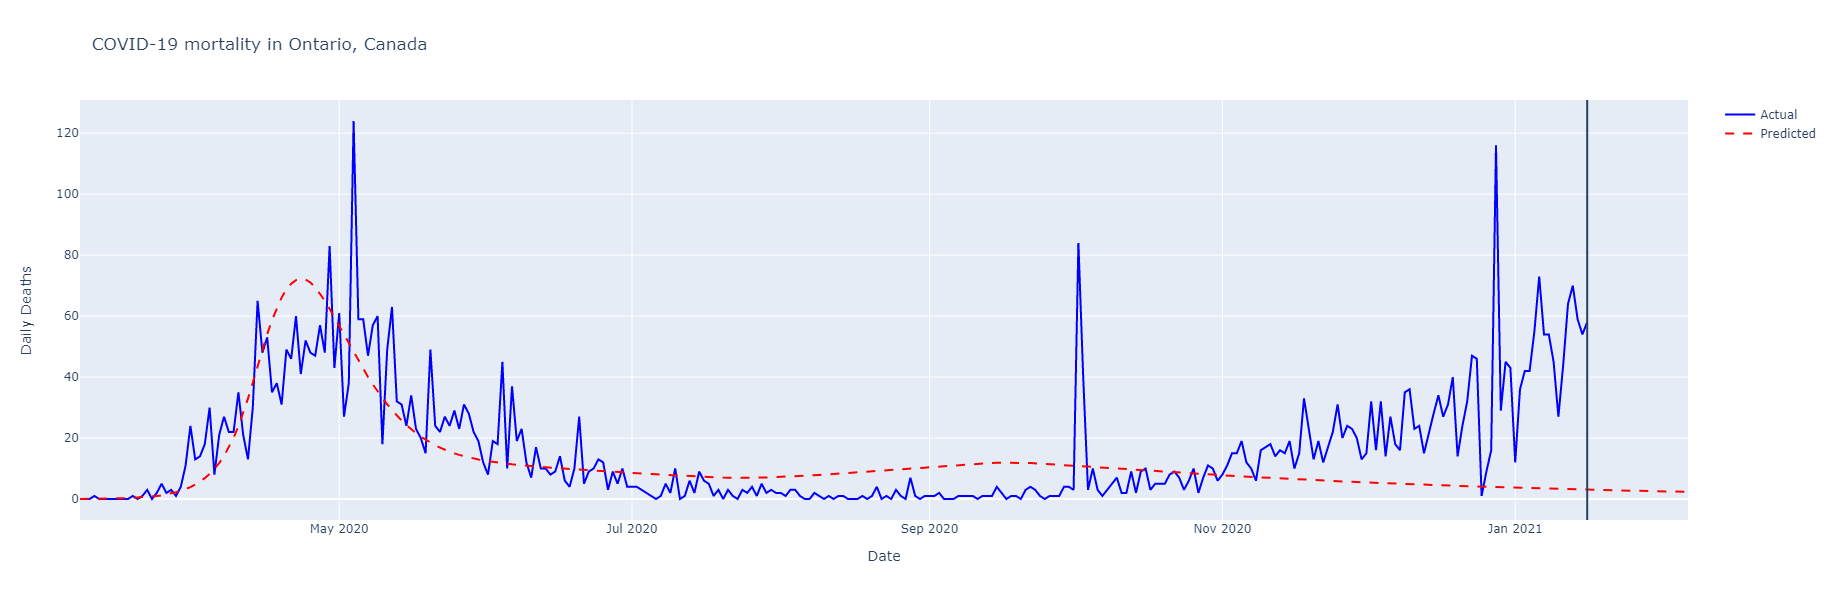

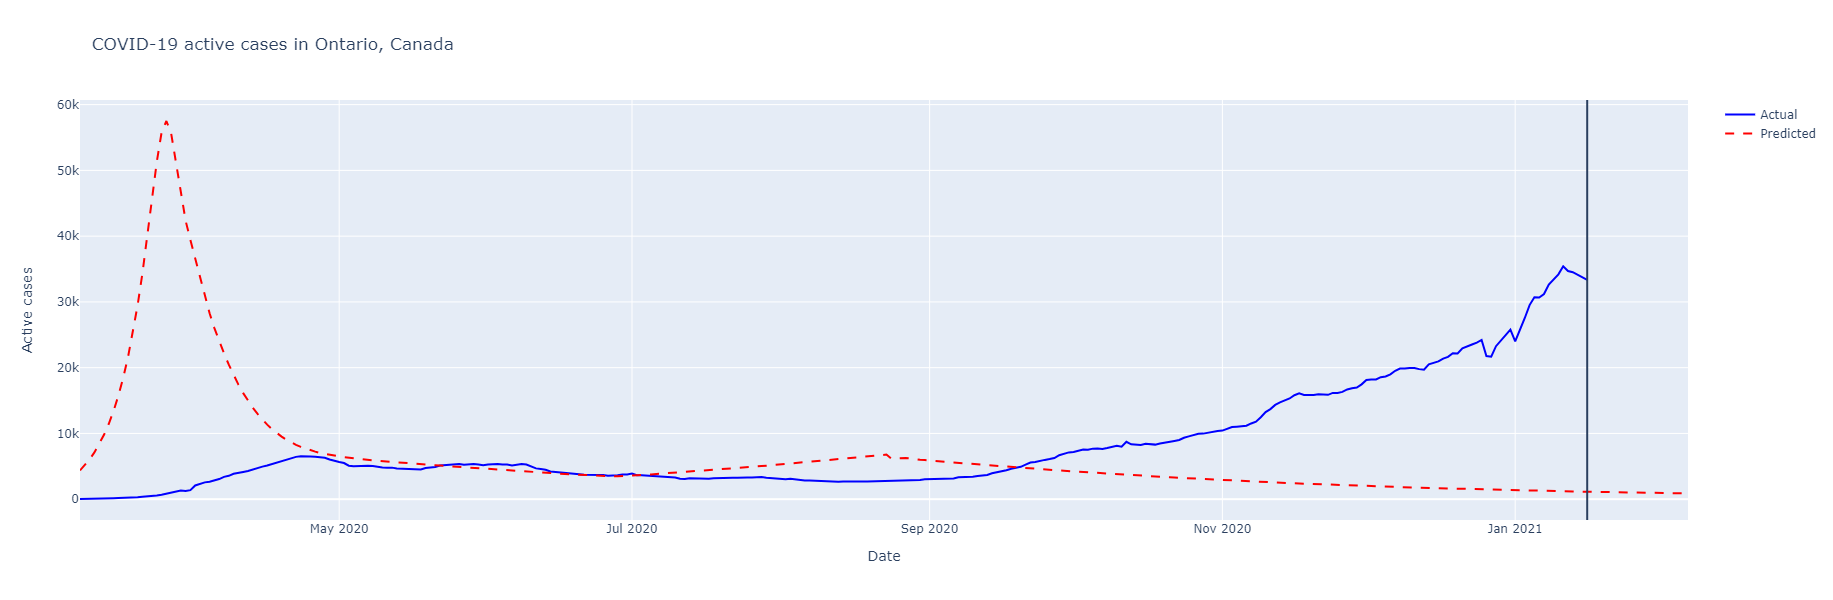

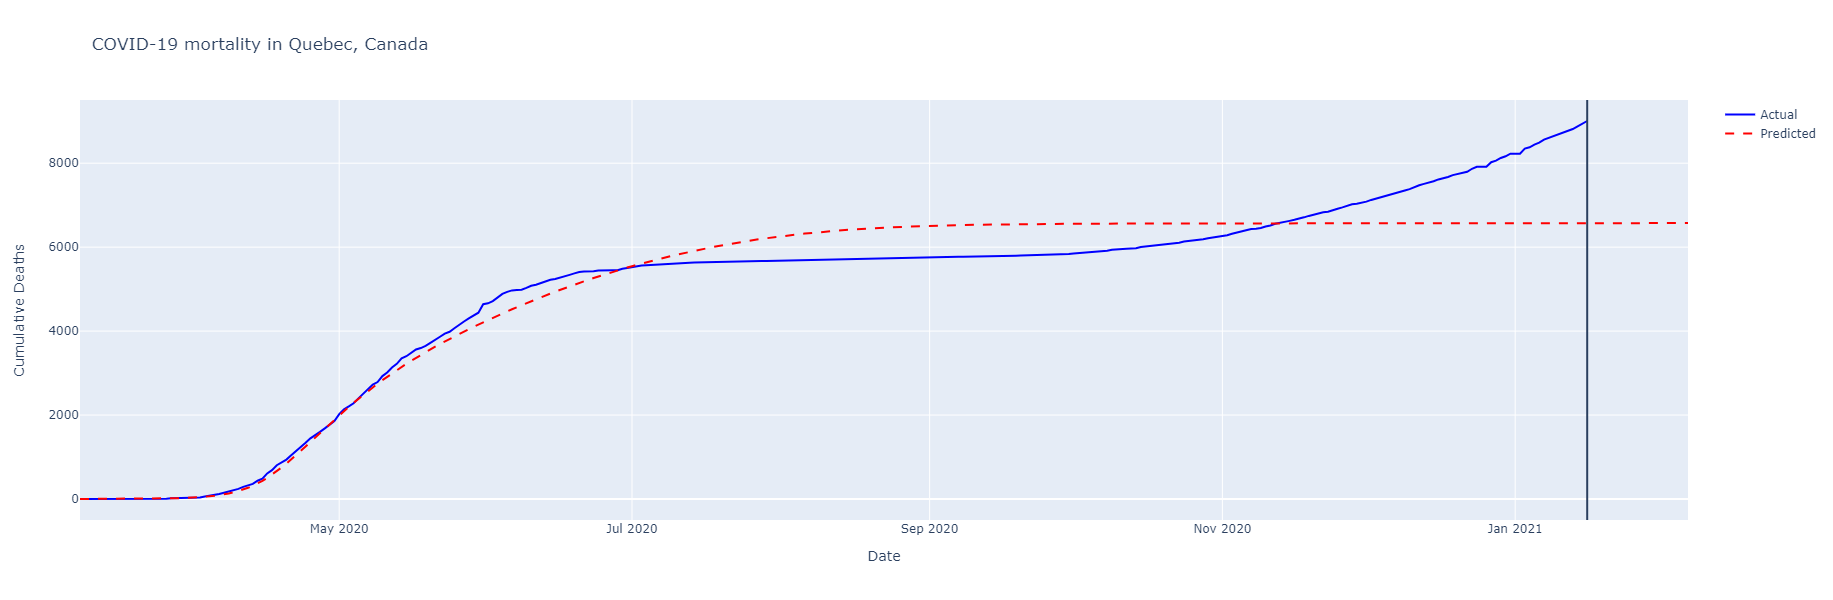

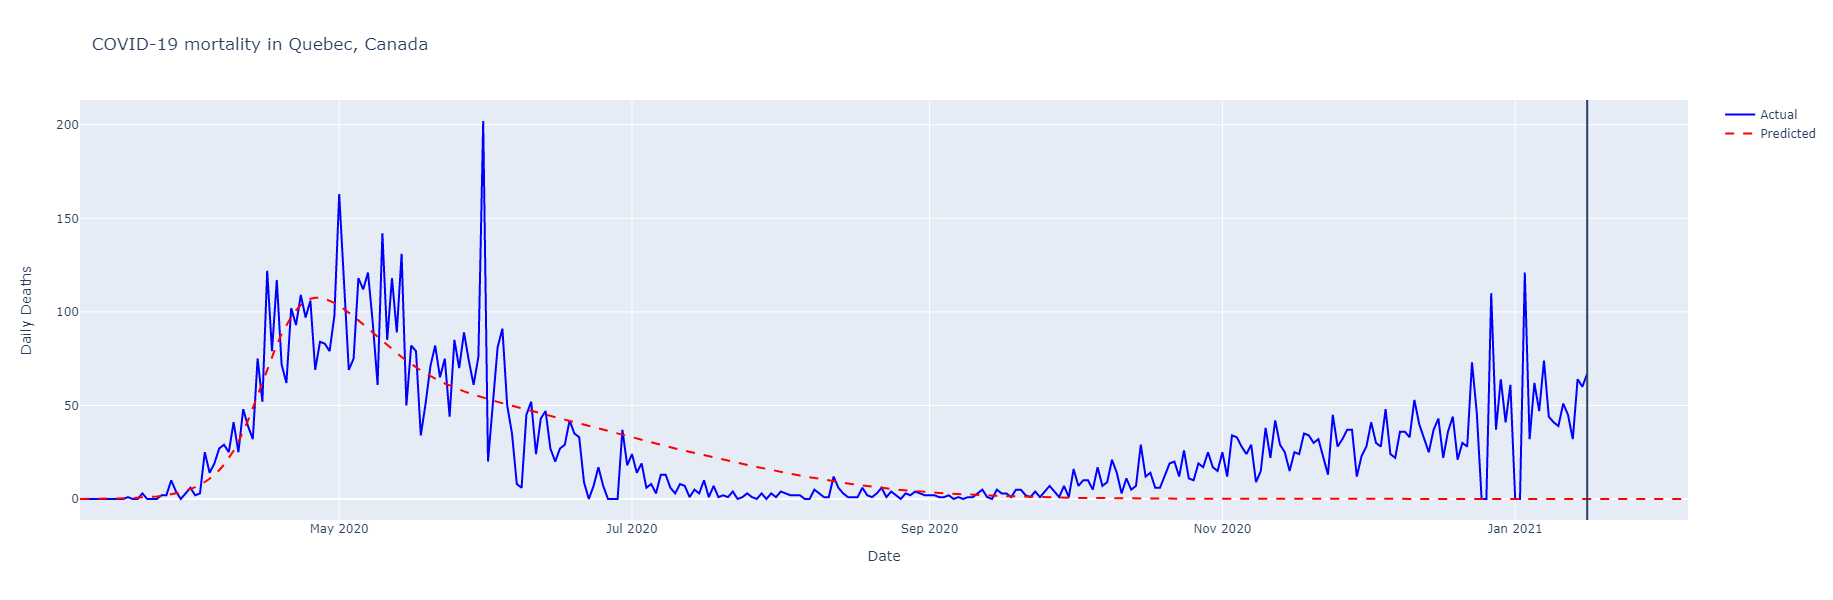

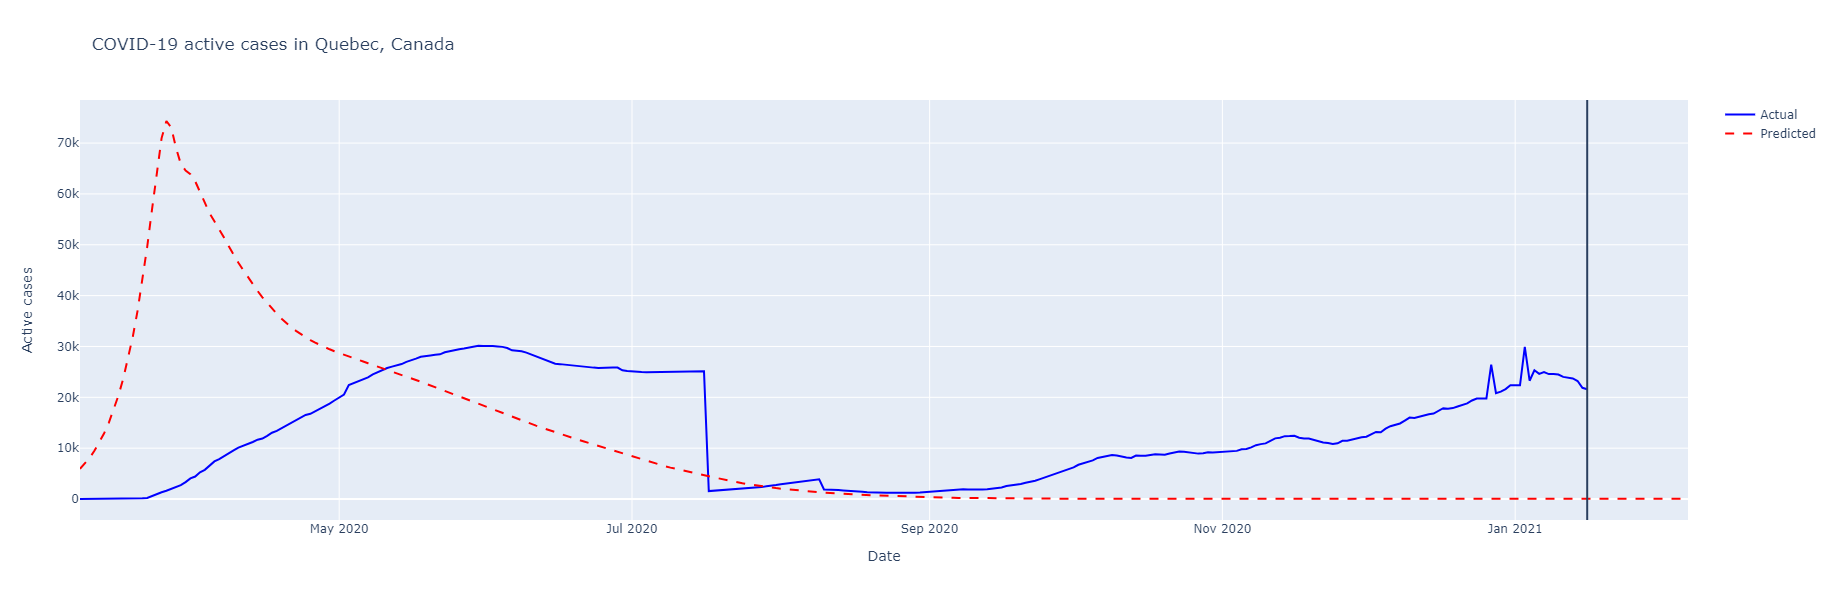

In [8]:
for province in provinces:
    province_forecasts = forecasts.query("province == @province")

    # Plot results for cumulative deaths
    plot_predictions(
        province_forecasts,
        y="cumulative_deaths",
        y_label="Cumulative Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

    # Plot results for daily deaths
    plot_predictions(
        province_forecasts,
        y="deaths",
        y_label="Daily Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

    # Plot results for daily deaths
    plot_predictions(
        province_forecasts,
        y="active_cases",
        y_label="Active cases",
        title=f"COVID-19 active cases in {province}, Canada",
        height=600,
    )

## Cross validation scores

### Differential evolution

### L-BFGS